作者： 姚舜禹  
もし SimProfile を用いて得られた結果や研究を公開発表する場合は、以下の論文を引用してください： 
https://doi.org/10.20944/preprints202510.1834.v1

SimProfile: A Monte Carlo Surface Profile Simulator with Data-Driven Parameter Calibration



インストール要件：  
システム：Windows 11 上の WSL の使用を推奨  
IDE：VSCode の使用を推奨  

環境設定：  
C++ の Eigen ライブラリが必要  
pybind11 が必要  
Python ライブラリ（numpy, pyvista, numba など）が必要  



WSL 上でのインストール手順例：

**Eigen のインストール**  
```bash
sudo apt update
sudo apt install libeigen3-dev
```

**pybind11 のインストール**  
```bash
sudo apt install pybind11-dev
```
または Python パッケージとして：
```bash
pip install pybind11
```

**Python ライブラリのインストール**  
```bash
pip install numpy numba
pip install pyvista[all]
```

SimProfile フォルダに移動して、以下のコマンドを実行してください：

```bash
pip install reaction/
```

In [1]:
import pyvista as pv
import numpy as np
import os
import postProcess
import particleGenerator
from numba import jit

import surface_normal

import cv2
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
import SimProfile

In [5]:
%pip install pyvista[all]

  Using cached rich-14.2.0-py3-none-any.whl.metadata (18 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
   ---------------------------------------- 0.0/781.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/781.0 kB ? eta -:--:--
   ---------------------------------------- 781.0/781.0 kB 32.4 MB/s  0:00:00
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/5.1 MB ? eta -:--:--
   -------- ------------------------------- 1.0/5.1 MB ? eta -:--:--
   ---------------------------------- ----- 4.5/5.1 MB 15.8 MB/s eta 0:00:01
   ---------------------------------------- 5.1/5.1 MB 12.0 MB/s  0:00:00
   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/914.9 kB ? eta -:--:--
   ---------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [ ]:
# cell size [x][y][z][FILMSIZE]

FILMSIZE = 4
zoom_in = 1.4
density = 20

In [ ]:
# hole

def inputFilm(jpg1):
    # image = cv2.imread("./sf_o2_20p_paper1.jpg")
    image = cv2.imread(jpg1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # zoom_in = 1.0
    # 调整图像大小，使它们具有相同的尺寸
    height, width = image.shape[:2]

    height = int(height/zoom_in)
    width = int(width/zoom_in)

    image = cv2.resize(image, (width, height))

    HardMasK = np.array(image)
    print("HardMasK.shape: ", HardMasK.shape)
    # FILMSIZE = 11 
    # Hard mask SF6_O2

    cellx = 60
    film = np.zeros((cellx, HardMasK.shape[1], HardMasK.shape[0], FILMSIZE), dtype=np.int32)
    # density = 20

    SiCut = 0
    for j in range(HardMasK.shape[0]):
    # for i in range(HardMasK.shape[1]):
        # print(j)
        # if HardMasK[j, 0] < 180 : # si
        #     SiCut = j

        for i in range(HardMasK.shape[1]):
            # if HardMasK[j, i] >= 100 and HardMasK[j, i] < 200: # hm
            if HardMasK[j, i] >= 100 and HardMasK[j, i] < 200 and i < HardMasK.shape[1]/2: # hm
                # film[:, i, -j, 0] = density
                SiCut = j
                film[:, i, -j, -1] = density*5
                film[:, -i, -j, -1] = density*5
            if HardMasK[j, i] > 180: # si
                # film[:, i, -j, -1] = density*5
                film[:, i, -j, 0] = density
        # print('SiCut: ', SiCut)

    # film[:, :, :HardMasK.shape[0] - SiCut, -1] = 0
    film[:, :, :HardMasK.shape[0] - SiCut+1, -1] = 0
    film[:, :, :HardMasK.shape[0] - SiCut+1, 0] = density

    # for x in range(film.shape[0]):
    #     for y in range(film.shape[1]):
    #         if film[x, y, HardMasK.shape[0] - SiCut, -1] != 0:
    #             print(f"x:{x}, y:{y}")
    #             film[x, y, HardMasK.shape[0] - SiCut, -2] = density  # undermask
    #             film[x, y, HardMasK.shape[0] - SiCut, -1] = 0  # undermask

    film[:, :, :5, 0] = density

    return film

In [ ]:
color_names = ['dimgray', 'cyan', 'black', 'red','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF', 'SiOxFy', 'mask']
geom = pv.Box()
p = pv.Plotter()


# film = inputFilm_benchmark_hole()
# film = inputFilm_pegasus()
film = inputFilm("./sf_250410_1_1.jpg")
# film = inputFilm("./cu_depo_0930.jpg")
layer =postProcess.layerLoop(film[:,:,:,:])
for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci])

p.enable_eye_dome_lighting()
p.add_legend(size=(0.2, 0.2))
p.show()

In [ ]:
def getStop(jpg2):
    image2 = cv2.imread(jpg2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # zoom_in = 1.0
    # 调整图像大小，使它们具有相同的尺寸
    height, width = image2.shape[:2]

    height = int(height/zoom_in)
    width = int(width/zoom_in)

    image2 = cv2.resize(image2, (width, height))

    HardMasK2 = np.array(image2)
    print("HardMasK.shape: ", HardMasK2.shape)
    # FILMSIZE = 11 
    # Hard mask SF6_O2

    film2 = np.zeros((2, HardMasK2.shape[1], HardMasK2.shape[0], FILMSIZE), dtype=np.int32)
    # density = 20

    SiCut = 0
    for j in range(HardMasK2.shape[0]):
    # for i in range(HardMasK2.shape[1]):
        # print(j)
        if HardMasK2[j, 0] < 180 : # si
            SiCut = j

        for i in range(HardMasK2.shape[1]):
            if HardMasK2[j, i] >= 100 and HardMasK2[j, i] < 200: # hm
                # film2[:, i, -j, 0] = density
                film2[:, i, -j, -1] = density*5
            if HardMasK2[j, i] > 180: # si
                # film2[:, i, -j, -1] = density*5
                film2[:, i, -j, 0] = density
        # print('SiCut: ', SiCut)

    film2[:, :, :HardMasK2.shape[0] - SiCut, -1] = 0

    film2[:, :, :5, 0] = density

    stopPointY = int(film2.shape[1]/2)

    for thick in range(film2.shape[2]):
        if np.sum(film2[int(film2.shape[0]/2),stopPointY, thick, :]) == 0:
            stopPointZ = thick
            break

    for thick in range(film2.shape[2]):
        if np.sum(film2[int(film2.shape[0]/2), :, thick, :]) == 0:
            topLayerZ = thick
            break
        

    print('stopPointY: ', stopPointY)
    print('stopPointZ: ', stopPointZ)
    print('topLayerZ: ', topLayerZ)
    return stopPointY, stopPointZ, topLayerZ

# 读取两张图像
# img1_path = "./sf_250410_1_1.jpg"
img2_path = "./sf_250410_1_2.jpg"

stopPointY, stopPointZ, topLayerZ = getStop(img2_path)

In [ ]:
# surface normal calculation

sumFilm = np.sum(film, axis=-1)
mirrorGap = 3
cellSizeX, cellSizeY, cellSizeZ = sumFilm.shape
film_label_index_normal, curvatures_field = surface_normal.build_film_label_index_normal(sumFilm, mirrorGap)

curvatures_field[:3, :, :] = curvatures_field[3:6, :, :]
curvatures_field[-3:, :, :] = curvatures_field[-6:-3, :, :]

cellid = np.ascontiguousarray(film_label_index_normal[:,:,:,0].copy(), dtype=np.int32)
cellnormal = np.ascontiguousarray(film_label_index_normal[:,:,:,-3:].copy(), dtype=np.double)
cellfilm = np.ascontiguousarray(film.copy(), dtype=np.int32)
cellindex = np.ascontiguousarray(film_label_index_normal[:,:,:,1:4].copy(), dtype=np.int32)

In [ ]:
# surface normal visualization

color_names = ['dimgray', 'blue', 'cyan', 'red','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF', 'SiOxFy', 'mask']

geom = pv.Box()
p = pv.Plotter()

layer = postProcess.layerLoop(film)

for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci],opacity=0.7)

plane = postProcess.transfer_to_plane(cellid, cellnormal)

point_cloud = pv.PolyData(plane[:, 3:6])
vectors = plane[:, :3]

point_cloud['vectors'] = vectors
arrows = point_cloud.glyph(
    orient='vectors',
    scale=10000,
    factor=3,
)

p.add_mesh(point_cloud, color='cyan', point_size=5.0, render_points_as_spheres=True)
p.add_mesh(arrows, color='lightblue', opacity= 0.1)

p.enable_eye_dome_lighting()
p.add_legend()
p.show()

In [ ]:
# set reaction table

react_table_equation =   np.array([[[-1,  1,  0,  0], #Si-SiFx
                                    [ 0, -1,  0,  0], #SiFx-vac
                                    [ 0,  0,  0,  0], #SiOxFy-F
                                    [ 0,  0,  0,  0]], #Mask-F

                                    [[-1,  0,  1,  0], #Si-SioxFy
                                    [ 0, -1,  1,  0], #SiFx-SioxFy
                                    [ 0,  0,  0,  0], #SioxFy-O
                                    [ 0,  0,  0,  0]], #Mask--O

                                    [[-1,  0,  0,  0], #Si-ion
                                    [ 0, -1,  0,  0], #SiFx-ion
                                    [ 0,  0, -1,  0], #SiOxFy-ion
                                    [ 0,  0,  0, -1]]], dtype=np.int32) #Mask-ion


# react_type_table = np.ones((4, 4), dtype=np.int32) # 1 for chemical transfer 
# react_type_table[2, :] = 2 # 2 for physics
# react_type_table[3, :] = 3 # 3 for redepo
# react_type_table[0, 1] = 4 # 4 for chemical remove

react_type_table =np.array([[1, 4, 1, 1],  # 4 for chemical remove; 1 for chemical transfer 
                            [1, 1, 1, 1],  
                            [2, 2, 2, 2],  # 2 for physics
                            [3, 3, 3, 3]]) #sf6-o2-ion


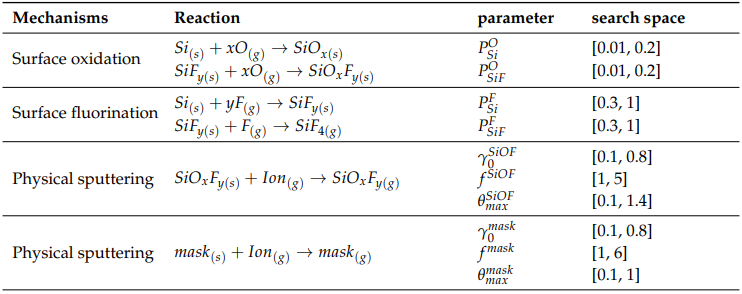

In [ ]:
react_prob_chemical = np.array([[0.9, 0.5, 0.0, 0.0],
                                [0.5, 0.5, 0.0, 0.0],
                                [1.0, 1.0, 1.0, 1.0]])

react_prob_chemical = np.ascontiguousarray(react_prob_chemical, dtype=np.double)



reflect_probability = np.ones((4, 4), dtype=np.double) # 1 for chemical transfer 
reflect_coefficient = np.ones((4, 4), dtype=np.double) # 1 for chemical transfer 

react_yield_p0 = np.array([0.00, 0.00, 1.00, 1.00])

#surface binding energy
film_eth = np.array([15, 15, 15, 15], dtype=np.double)

# deprecated Reflection probability curve
rn_coeffcients = np.array([[0.9423, 0.9434, 2.742, 3.026], # c1 c2 c3 c4
                            [0.9620, 0.9608, 2.542, 3.720],
                            [0.9458, 0.9445, 2.551, 3.735],
                            [1.046, 1.046, 2.686, 4.301]])

sputter_yield_coefficient = np.array([  [0.5, 2, np.pi/4],
                                        [0.5, 2, np.pi/4],
                                        [0.5, 2, np.pi/4],
                                        [0.5, 2, np.pi/4]])

E_decrease = np.zeros((3,4))

In [ ]:
def sputter_yield_angle(gamma0, f, thetaMax):
    # f = -np.log(gammaMax_2)/(np.log(np.cos(gammaMax_2*gamma0)) + 1 - np.cos(thetaMax))
    # print('log: ', np.log(gammaMax_2))
    s = f*np.cos(thetaMax)
    # s = s2*f
    theta = np.arange(0, np.pi/2, 0.01)
    cos_theta = np.cos(theta)
    cos_theta[cos_theta < 1e-8] = 1e-8  # 避免除以0和极小值导致溢出

    # print("f: ", f)
    sputterYield = gamma0*cos_theta**(-f)*np.exp(-s*(1/cos_theta - 1))
    # print("s", s)
    # sputterYield = gamma0*cos_theta**(-0.5)*np.exp(-s*(1/cos_theta - 1))
    sputterYield[-1] = 0
    theta[-1] = np.pi/2
    yield_hist = np.zeros((2, theta.shape[0]))

    yield_hist[0, :] = sputterYield
    yield_hist[1, :] = theta
    return yield_hist


sputter_yield_coefficient = [0.5, 2, np.pi/4]
yield_hist = sputter_yield_angle(sputter_yield_coefficient[0], sputter_yield_coefficient[1], sputter_yield_coefficient[2])
plt.plot(yield_hist[1,:], yield_hist[0,:])

In [ ]:
chemical_angle_v1 = (89/180)*np.pi
chemical_angle_v2 = (90/180)*np.pi

In [ ]:
# set initial particle positions


def posGenerator_top_nolength(IN, cellSizeX, cellSizeY, cellSizeZ, emptyZ):
    # emptyZ = 10
    position_matrix = np.array([np.random.rand(IN)*cellSizeX, \
                                np.random.rand(IN)*cellSizeY, \
                                np.random.uniform(0, emptyZ, IN) + cellSizeZ - emptyZ], dtype=np.double).T
    return position_matrix

In [ ]:
folder_path = "./example_etching/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹已创建：{folder_path}")
else:
    print(f"文件夹已存在：{folder_path}")



react_prob_chemical[0, 0] = 0.6 #Si-SiFx
react_prob_chemical[0, 1] = 0.6 #SiFx-vac

react_prob_chemical[1, 0] = 0.06 #Si-SioxFy
react_prob_chemical[1, 1] = 0.06 #SiFx-SioxFy

sigma_ion = 0.05

Ar_ratio = 0.2

sputter_yield_coefficient[2, 0] = 0.5 #['gamma_0_SiOF']
sputter_yield_coefficient[2, 1] = 2 #['f_SiOF'] 
sputter_yield_coefficient[2, 2] = np.pi/4 #['theta_max_SiOF'] 

sputter_yield_coefficient[3, 0] = 0.5 #['gamma_0_mask']
sputter_yield_coefficient[3, 1] = 2 #['f_mask'] 
sputter_yield_coefficient[3, 2] = np.pi/4 #['theta_max_mask'] 

E_decrease[:,:] = 10
reflect_probability[0, :] = 0
reflect_probability[1, :] = 1
reflect_probability[2, :] = 0.1
reflect_probability[2, 3] = 1


simulation_step_rm = int(2e6)
N = int(9e6)

o2_ratio = 0.5
# particle_list = [[N, 0, 'cosn', 50, cosn]] # [int(N*Ar_ratio), 2, 'cosn', 50, cosn]
# particle_list = [[int(N*(1-Ar_ratio)), 0, 'maxwell', 50, 300, 9], [int(N*Ar_ratio), 2, 'cosn', 50, cosn]]
particle_list = [[int(N*(1-Ar_ratio)*(1-o2_ratio)), 0, 'maxwell', 50, 300, 9], [int(N*(1-Ar_ratio)*(o2_ratio)), 1, 'maxwell', 50, 300, 16], [int(N*Ar_ratio), 2, 'guass', 50, sigma_ion]]
# particle_list = [[int(N), 0, 'maxwell', 50, 300, 9]]
# particle_list = [[int(N), 0, 'maxwell_energy', 50, 300, 9]]

vel_matrix = particleGenerator.vel_generator(particle_list)

pos = posGenerator_top_nolength(vel_matrix.shape[0], cellSizeX, cellSizeY, cellSizeZ, (cellSizeZ - topLayerZ - 3))
pos = np.ascontiguousarray(pos, dtype=np.double)

vel = vel_matrix[:, :3].copy()
vel = np.ascontiguousarray(vel, dtype=np.double)
id  = vel_matrix[:, -1].astype(np.int32).copy()
E  = vel_matrix[:, -2].copy()
# **创建临时 pickle 文件**

# max_particles = 256000
# max_particles = 512000
# max_particles = 1024000
# max_particles = 2048000
max_particles = 4096000
seed = 125
simulation = SimProfile.Simulation(seed, cellSizeX, cellSizeY, cellSizeZ, FILMSIZE, density, max_particles)

simulation.set_all_parameters(react_table_equation, react_type_table, reflect_probability, reflect_coefficient,
                            react_prob_chemical, react_yield_p0, 
                            film_eth, rn_coeffcients, E_decrease)

simulation.input_sputter_yield_coefficient(sputter_yield_coefficient)
simulation.inputCell(cellid, curvatures_field, cellindex, cellnormal, cellfilm)
simulation.inputParticle(pos, vel, E, id)


depo_or_etch = -1 # depo for 1, etch for -1 
ArgonID = 2
diffusion = False
diffusion_coeffient = 3.0
diffusion_distant = 1
redepo = False
# reflect_probability = 0.1

relaxTime = 100
# **运行 Simulation**
needrecompute = simulation.runSimulation(simulation_step_rm, ArgonID, depo_or_etch, redepo, diffusion, diffusion_coeffient, diffusion_distant, stopPointY, stopPointZ, chemical_angle_v1, chemical_angle_v2, relaxTime)
# needrecompute = simulation.runSimulation(data["simulation_step_rm"], 2, data["reflect_coefficient"], data["E_decrease"], data["stopPointY"], data["stopPointZ"], data["chemical_angle_v1"], data["chemical_angle_v2"])
print(f"needrecompute: {needrecompute}")

iter = 1
if needrecompute == 0:
    print("Simulation finished")
    # typeID_array, film_array = simulation.cell_data_to_numpy()
    typeID_array, film_array, potential_array = simulation.cell_data_to_numpy()
    normal_array = simulation.normal_to_numpy()
    np.save(f"./{folder_path}/film_{iter}.npy", film_array)

In [ ]:
color_names = ['dimgray', 'blue', 'cyan', 'red','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiF', 'SiOxFy', 'mask']
geom = pv.Box()
p = pv.Plotter()

n = 35
film = np.load(f'./{folder_path}/film_{iter}.npy')
# film = inputFilm_pegasus()
# film = inputFilm("./sf_250410_1_1.jpg")
# film = inputFilm("./cu_depo_0930.jpg")
layer =postProcess.layerLoop(film[:,:,:,:])
for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci])

p.enable_eye_dome_lighting()
p.add_legend(size=(0.2, 0.2))
p.show()

In [ ]:
import matplotlib.patches as mpatches

def overlap_show(n, img1_path, img2_path, path_dir, overlap_range=np.array([[0, -1], [0, -1]])):
    # 读取两张图像
    # img1_path = "./sf_o2_paper1.jpg"
    # img2_path = "./sf_o2_paper2.jpg"

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # n = 1
    # binary1= np.load(f'./save_film/film_0_1_0520_1.npy')
    binary1 = np.load(f'./{path_dir}/film_{n}.npy')

    binary1 = np.sum(binary1, axis=-1)
    binary1 = binary1[int(binary1.shape[0]/2), :, :]
    new_binary1 = np.zeros((binary1.shape[1], binary1.shape[0]))

    for i in range(binary1.shape[1]):
        new_binary1[new_binary1.shape[0] - i-1, :] = binary1[:, i]

    img1 = new_binary1


    # 调整图像大小，使它们具有相同的尺寸
    height, width = img1.shape[:2]
    img2_resized = cv2.resize(img2, (width, height))

    # 转换为灰度图
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)

    # 二值化处理
    # _, binary1 = cv2.threshold(gray1, 80, 255, cv2.THRESH_BINARY)
    binary1 = new_binary1


    _, binary2 = cv2.threshold(gray2, 80, 255, cv2.THRESH_BINARY)

    # binary2 = cv2.bitwise_not(binary2).astype(np.uint8)
    # binary1 = binary1.astype(np.uint8)

    binary1 = (binary1 > 10).astype(np.uint8) * 255
    # binary2 = (binary2 > 128).astype(np.uint8) * 255

    x1 = overlap_range[0, 0]
    x2 = overlap_range[0, 1]
    y1 = overlap_range[1, 0]
    y2 = overlap_range[1, 1]
    binary1 = binary1[x1:x2, y1:y2]
    binary2 = binary2[x1:x2, y1:y2]
    # 计算重叠区域
    intersection = binary1 == binary2  # 计算交集

    SimCD = intersection == binary1
    ExpCD = intersection == binary2
    # print(intersection)
    # print(binary1)
    # print(binary2)

    overlap_ratio = np.sum(intersection) / (intersection.shape[0]*intersection.shape[1])


    overlap = intersection*0.5
    overlap[0,0] = 0.4
    overlap[0,-1] = 0.6
    overlap[SimCD] = 0.4
    overlap[ExpCD] = 0.6

    # overlap_ratio = np.sum(intersection) / (intersection.shape[0]*intersection.shape[1])


    # overlap = intersection*255
    # overlap_ratio = np.sum(overlap) / np.sum(binary2)  # 计算相对于 mask 的重叠度
    simulation = (new_binary1 > 10).astype(np.uint8) * 255

    simulation[simulation < 255] = 40
    simulation[simulation == 255] = 60
    simulation[0,0] = 20
    # simulation[0,0] = 0
    _, experiment = cv2.threshold(gray2, 80, 255, cv2.THRESH_BINARY)
    experiment[experiment < 255] = 60
    experiment[experiment == 255] = 40
    experiment[0,0] = 80

    # 显示结果
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    cmap = plt.colormaps['RdBu']
    axes[0].imshow(simulation, cmap=cmap)
    axes[0].set_title("simulation")

    axes[1].imshow(experiment, cmap=cmap)
    axes[1].set_title("experiment")

    # cmap = plt.colormaps['RdBu']
    axes[2].imshow(overlap, cmap=cmap)

    # axes[3].imshow(overlap[:10, :10], cmap='gray')

    red_patch = mpatches.Patch(color='red', label='Sim > Exp')
    blue_patch = mpatches.Patch(color='blue', label='Sim < Exp')

    axes[2].legend(handles=[red_patch, blue_patch])
    axes[2].set_title(f"Union - Intersection")

    for ax in axes:
        ax.axis("off")

    plt.show()

    # 输出重叠率
    print('intersection:', (intersection.shape[0]*intersection.shape[1]) - np.sum(intersection))

    # params = np.load(f'./{path_dir}/hyperopt/iteration_{n}.npy', allow_pickle=True).item()
    # print(params)


# path = "calibration_1014_paper_gpmin"
overlap_show(iter, "./sf_250410_1_1.jpg", "./sf_250410_1_2.jpg", folder_path)